In [2]:
#Broker imports:
import py_at_broker as pab
from IPython.display import clear_output

import pylab as pl
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 
#Non broker imports:

from IPython import display
import math as math
import pandas as pd
import time
import cv2
import numpy as np
import numpy.random as npr

%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km
from robo_cheesecake.engine import *
import SLRobot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext autoreload
%autoreload 2
from toolbox import object_detection_toolbox as odt
import os
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
look_left = np.array([-0.31940988, -0.38355264,  0.24733287, -1.79066074, 1.4 ,
        1.59099698,  0.83008564])
look_right = np.array([-0.31940988, -0.38355264,  0.24733287, -1.79066074, -1.4 ,
        1.59099698,  0.83008564])
home_pos = np.array([-0.3222667,  -0.39487693,  0.25124076, -1.78770602, -0.0087735,   1.58738244,   0.85377795])

In [5]:
def get_depth_rgb_images_from_msg():
    msg = b.recv_msg("realsense_images", True)
    rgb = msg.get_rgb()
    dim_rgb = msg.get_shape_rgb()

    depth = msg.get_depth()
    dim_depth = msg.get_shape_depth()

    imrgb = np.reshape(rgb, dim_rgb)
    imdepth = np.reshape(depth, dim_depth)
    
    imdepth = cv2.resize(imdepth, dsize = (imrgb.shape[1], imrgb.shape[0]), interpolation = cv2.INTER_NEAREST)
    return (imrgb, imdepth)
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '../faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/dlrc1/Documents/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

with tf.device('/device:GPU:0'):
    detection_graph = tf.Graph()
    odt.load_model(PATH_TO_FROZEN_GRAPH, detection_graph)
    category_index = odt.create_category_index(PATH_TO_LABELS)
    with detection_graph.as_default() as graph:
        tensor_dict = odt.create_tensor_dict(['num_detections', 'detection_boxes', 'detection_scores',
        'detection_classes', 'detection_masks'])
    sess = tf.Session(graph=detection_graph)
    

def GripApple(current_counter):
    msg = pab.gripper_cmd_msg()
    msg.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
    msg.set_fnumber(current_counter)
    msg.set_cmd_t(pab.CmdType.Grasp)
    msg.set_width(0.065)
    msg.set_speed(0.8)
    msg.set_force(10)

    msg.set_epsilon_in(0.005)
    msg.set_epsilon_out(0.005)

    b.send_msg("franka_gripper", msg)
    time.sleep(0.2)
    current_counter=current_counter+111
    return current_counter


def ReleaseApple(current_counter):
    msg = pab.gripper_cmd_msg()
    msg.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
    msg.set_fnumber(current_counter)
    msg.set_cmd_t(pab.CmdType.Move)
    msg.set_width(80)
    msg.set_speed(0.3)
 

    b.send_msg("franka_gripper", msg)
    time.sleep(0.2)
    current_counter=current_counter+111
    return current_counter


def GoHome(current_counter):
    Home=np.array([-0.3222667,  -0.39487693,  0.25124076, -1.78770602, -0.0087735,   1.58738244,   0.85377795])
    sleep_time = samples
    go_time = samples-0.1

    frame=current_counter+1
    target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Home, go_time=go_time)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(sleep_time)
    
    return current_counter

In [5]:
b.request_signal("franka_state", pab.MsgType.franka_state, True)
current_counter=0

In [6]:
b.request_signal("realsense_images", pab.MsgType.realsense_image)


True

In [7]:
b.register_signal("franka_gripper", pab.MsgType.gripper_cmd)

Address broker could not acceppt the offered signal franka_gripper. Is there another signal with the same name? Trying to reconnect
Reconnection to signal <franka_gripper> successful


True

In [8]:
b.request_signal("franka_lidar", pab.MsgType.franka_lidar)

True

In [9]:
lidar_msg = b.recv_msg('franka_lidar', 0)
print(lidar_msg.get_data())

[8190  878 8191  798 8191 8190 1067  396 8190]


In [6]:
while True: 
    clear_output(wait=True)
    time.sleep(0.05)
    lidar_msg = b.recv_msg("franka_lidar", 0)
    print(lidar_msg.get_data())



Exception: Signal franka_lidar is unknown. Is it registered as input?

In [6]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

True

In [7]:
%load_ext autoreload
%autoreload 2
from toolbox import obstacle_detector as od


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.7.0


In [13]:
loc = od.localizer()


In [14]:
prefix = 'models/retrained_models_without_broken_lidar/model_lidar_5000_epochs'
predictor, predictions, measurements = od.init_lidar_predictor(b, timesteps = 5, model_prefix=prefix)

Done loading model 0
Done loading model 1
Done loading model 2
Done loading model 3
Done loading model 4
Done loading model 5
Done loading model 6
Done loading model 7
Done loading model 8
initializing measurements: .....done


/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


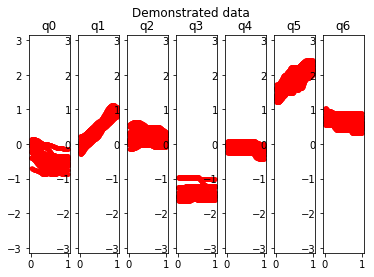

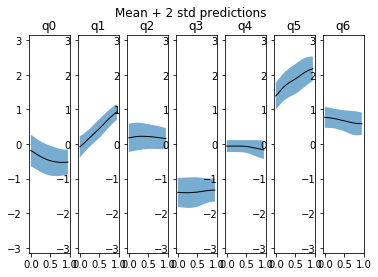

In [8]:

df_generated, N=robotoolbox.PrepareData('JointsFinalPresentation_take2.p')

params = {'D' : 7, 'K' : 5, 'N' : N}
RobotSaysHi=ProMP(identifier='RobotSaysHi', TrainingData=df_generated, params=params)
RobotSaysHi.RegularizedLeastSquares() #Choice for l from [1]
RobotSaysHi.GenerateDemoPlot(xvariable="Phases")  
RobotSaysHi.MeanAndStdPredictionPlot(factor=2)
MaxTime=8
samples=1  


class RobotMap:
    
    """Map framework for robot control using lidars and cameras"""
    
    def __init__(self, ProMP, sleep_time=1, go_time=0.9, MaxTime=8):
        self.ProMP=ProMP
        self.identifier=ProMP.identifier
        self.step=0        
        self.controlsleep=True
        self.polarity=1 # Polarity is -1 when the robot goesbackwards. 
        self.Params= {'sleep_time' : sleep_time, 'go_time' :  go_time, 'MaxTime' : MaxTime}
        from toolbox import movementtoolbox as mt 
    
    def SetObjectTarget(self, Qtarget, ztarget=1):
        self.Object_Target_Qtarget=Qtarget
        self.Object_Target_ztarget=ztarget
        
    @staticmethod
    def MeanQ(z, ProMP):    
        return ProMP.GeneratePrediction(w=ProMP.estimate_m, Z=z)[1]
        
    def GeneratePath(self, ProMPconstrains=[0, 0.3, 0.5]):
        """ProMP constrains is an array that constrains via points to the mean of the ProMP"""
        
        
           
        Object_Qtarget=self.Object_Target_Qtarget
        Object_ztarget=self.Object_Target_ztarget
        
        Qtarget=[]
        Ztarget=[]
        for constrain in ProMPconstrains:
            Qtarget.append(self.MeanQ(constrain, self.ProMP))
            Ztarget.append(constrain)
        Qtarget.append(Object_Qtarget)
        Ztarget.append(Object_ztarget)                  
        w_des=self.ProMP.Condition_JointSpace(Qtarget=Qtarget, Ztarget=Ztarget)        

        T, Q= RobotSaysHi.GetJointData(w=w_des, robotrate=samples, MaxTime=MaxTime)
        
        Q[-1,:]=Object_Qtarget ## This heuristic is not very elegant but it is necesary
        robotoolbox.PlotTrajectory(T, Q)
        plt.show()
        
        self.Path=Q
        self.CurrentQ=self.Path[self.step,:]
        self.MaxSteps=self.Path.shape[0]
        
      
        
    def Execute(self):
        global current_counter
        go_time=self.Params['go_time']
        sleep_time=self.Params['sleep_time']
        
        target_msg, current_counter = mt.create_message(counter=current_counter, ctrl_t = 1, pos = self.CurrentQ, go_time=go_time)
        b.send_msg('franka_target_pos', target_msg)
        if self.controlsleep:
            time.sleep(sleep_time)
        
        current_counter+=1
        pass
    
    def DoStepForward(self):
        print("Current Step: ", self.step, ". Now moving to Step: ",self.step+1)
        self.CurrentQ=self.Path[self.step,:]
        self.step+=1
        self.Execute()

    def DoStepBack(self):
        print("Current Step: ", self.step, ". Now moving to Step: ",self.step-1)
        self.CurrentQ=self.Path[self.step,:]
        if (self.step>=1):
            self.step-=1
            self.Execute()
        else:
            pass

        
    def DoStep(self):
        if self.polarity==1:
            self.DoStepForward()
        if self.polarity==-1:
            self.DoStepBack()
            
            
        
        
    def GoToStartPosition(self):
        global current_counter
        current_counter=GoHome(current_counter)
        #current_counter=ReleaseApple(current_counter)
        time.sleep(3)
        self.Reset()

        
    def FollowBlindly(self):
        self.Execute() #Goes to step zero
        for step in range(self.step,self.MaxSteps):
            
            self.DoStepForward()
            
        
    def Reset(self):
        self.step=0
        self.CurrentQ=self.Path[self.step,:]
       




In [16]:
current_counter=GoHome(current_counter)
time.sleep(3)
current_counter=ReleaseApple(current_counter)

In [9]:
def FindObjectNN(CommonObject='apple'):
    imrgb, imdepth = get_depth_rgb_images_from_msg()
    start_time = time.time()
    output_dict = odt.run_inference_for_single_image_test(imrgb, tensor_dict, sess)
    #print('Iteration %d: %.3f sec'%(i, time.time()-start_time))
    out = odt.visualize_pred_for_single_img(imrgb, output_dict, category_index)

    Q = b.recv_msg('franka_state', -1).get_j_pos()
    result, boxes = odt.get_boxes_with_label_and_threshold(CommonObject, 0.5, output_dict, imdepth, Q, category_index)

    target_pos = np.zeros(3)
    #target_pos = np.array([0.6, 0.0, 0.1 ])
    np.copyto(target_pos, result[0,0])
    target_pos[0]  = target_pos[0]+0.005*target_pos[0]
    target_pos[1] = target_pos[1]+0.13*target_pos[1]
    target_pos[2] += 0.03

    #target_pos[1] += 0.05 #offset
    #target_pos[1] =- target_pos[1]
    #print(target_pos)
    print('result:', target_pos)

    return target_pos


In [10]:
sleep_time = samples
go_time = 1.8*samples
z=1

ApplePos=FindObjectNN(CommonObject='apple')

def IKapple(ProMP, ApplePos):
    prediction_pro=ProMP.GeneratePrediction(Z=1)[1]

    bp= SLRobot.FK(prediction_pro.reshape(1,-1))[0,50:56] # Uses the mean ProMP orientation
    bp[0:3]=ApplePos

    j_ik = km.inverse_kin_6d(bp,prediction_pro)
    end_pos=j_ik[0]

    EF_FK = SLRobot.FK(np.array([end_pos]))

    #print(end_pos)
    #print('desired c pose:', bp)
    #print('c pose:', EF_FK[0,50:56])



    return end_pos

    
Q_des=IKapple(RobotSaysHi, ApplePos)
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m), Q_des], Ztarget=[0,z])        
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m),PredZ(0.3) ,PredZ(0.35) , Q_des], Ztarget=[0,0.3,0.35,z])        

#T, Q= RobotSaysHi.GetJointData(w=w_des, robotrate=samples, MaxTime=MaxTime)

#Q[-1,:]=end_pos
#robotoolbox.PlotTrajectory(T, Q)

#Qp,Qpp=robotoolbox.GetAccel(Q,T)
#robotoolbox.PlotAccel(T, Qpp)
#print(Q.shape)



CurrentMap=RobotMap(ProMP=RobotSaysHi, sleep_time=sleep_time, go_time=go_time, MaxTime=MaxTime)
CurrentMap.SetObjectTarget(Q_des, ztarget=1)
CurrentMap.GeneratePath(ProMPconstrains=[0,0.3,0.4])
#CurrentMap.FollowBlindly()
#current_counter=GripApple(current_counter)
#time.sleep(0.5)
#CurrentMap.GoToStartPosition()

#current_counter=ReleaseApple(current_counter)

Exception: Signal realsense_images is unknown. Is it registered as input?

In [28]:
current_counter=ReleaseApple(current_counter)

Position_timer = 0 
check_for_error = 0
sampling_rate = 0.05
lidars = []
joints = []

pos_counter = -1

samples = 1
sleep_time = samples
go_time = 1.8*samples

err_count = 0

CurrentMap.GoToStartPosition()
CurrentMap.controlsleep=False
first_round = True

while(CurrentMap.step<CurrentMap.MaxSteps):
    
    if not first_round:
        time.sleep(sampling_rate)
    else: 
        time.sleep(0.1)
        first_round = False
        
    state_msg = b.recv_msg("franka_state", 0)
    lidar_msg = b.recv_msg("franka_lidar", 0)
    
    lidars.append(lidar_msg.get_data())
    joints.append(state_msg.get_j_pos())
    
    if (lidar_msg.get_data() > 9000).any(): 
        print('lidar signal stopped')
        break
    
    check_for_error += 1
    Position_timer += sampling_rate
    
    if Position_timer > sleep_time*2:
        
        CurrentMap.DoStep()
        Position_timer = 0 

        
        
        
    if check_for_error > 10:  
        clear_output(wait = True)
        prediction, measurement = predictor.predict_timeseries(joint_data=np.array(joints), true_lidar=np.array(lidars))
        #measurement = medfilt(measurement, 5)
        #od.calc_error(predictor, predictions, measurements, np.array(lidars), np.array(joints), 0.4)
        error, idx = od.compare2threshold(prediction, measurement, 0.3, all_errors = True)
        
        if error: 
            if type(idx) == int:
                #location = loc.localize_lidars(joint_angles=state_msg.get_j_pos())
                lidar_measurement=lidar_msg.get_data()
                obstacle = loc.localize_obstacle(joint_pos=state_msg.get_j_pos(),
                                                 lidar_measurement=lidar_measurement, 
                                                 lidar_index=idx)
                print('location of obstacle', obstacle)
                print('current lidar value', lidar_measurement)
                print('lidar positions ', loc.localize_lidars(state_msg.get_j_pos()))
                coll = loc.predict_collision(future_joint_angels=CurrentMap.Path[pos_counter+1:].T, obstacle_location=obstacle)
                print(coll)
                #plt.plot(prediction[:, idx], label = 'prediction')
                #plt.plot(measurement[:, idx], label = 'measurement')
                #plt.title('error in lidar {}'.format(idx))
                #plt.legend()
                #plt.savefig('error'+str(err_count)+'.png')     
                #plt.show()

                if coll[0]: 
                    #clear_output()
                    print('returning to avoid collision')
                    CurrentMap.GoToStartPosition()
            
                    #time.sleep(2)
                    coll_time = coll[1]


                

            if type(idx) == np.ndarray: 
                colls = []
                coll_times = []
                #location = loc.localize_lidars(joint_angles=state_msg.get_j_pos())
                lidar_measurement=lidar_msg.get_data()
                for i in idx:             
                    obstacle = loc.localize_obstacle(joint_pos=state_msg.get_j_pos(),
                                                 lidar_measurement=lidar_measurement, 
                                                 lidar_index=i)
                    print('location of obstacle', obstacle)
                    print('current lidar value', lidar_measurement)
                    #print('lidar positions ', loc.localize_lidars(state_msg.get_j_pos()))
                    coll = loc.predict_collision(future_joint_angels=CurrentMap.Path[pos_counter+1:].T, obstacle_location=obstacle)
                    colls.append(coll[0])
                    coll_times.append(coll[1])
                #plt.plot(prediction[:, idx], label = 'prediction')
                #plt.plot(measurement[:, idx], label = 'measurement')
                #plt.title('error in lidar {}'.format(idx))
                #plt.legend()
                #plt.savefig('error'+str(err_count)+'.png')     
                #plt.show()

                if np.array(colls).any(): 
                    #clear_output()
                    print('returning to avoid collision')
                    coll_times = [c for c in coll_times if c is not None]
                    print("Master potato", coll_times, colls)

                    coll_time = min(coll_times)
                    
                    CurrentMap.GoToStartPosition()

                    time.sleep(10)


                
        lidars = []
        joints = []       
        check_for_error = 0
                
            #err_count +=1
            #time.sleep(1)

        
        
    
time.sleep(1)

#current_counter=GripApple(current_counter)
#time.sleep(0.5) 
#CurrentMap.GoToStartPosition()


        
    #save_and_send+=0.1

Deviation of 0.64 in liadar 7.
obstacle found in front left top
location of obstacle [0.326 0.074 0.532]
current lidar value [8190 8191  650  479 8191 8190 8191  146 8190]
possible collision in 5 steps
returning to avoid collision
Master potato [5] [True]


KeyboardInterrupt: 

In [ ]:
a = [1, 4, None]
[c for c in a if c is not None]

In [ ]:
CurrentMap.GoToStartPosition()

target_msg, current_counter = mt.create_message(counter=current_counter+1, ctrl_t = 1, pos = look_right, go_time=2)
b.send_msg('franka_target_pos', target_msg)
time.sleep(5)

try:
    PersonPos=FindObjectNN(CommonObject='person')
    time.sleep(2)
    PersonPos[1] = max(PersonPos[1], -0.6)
    target_msg, current_counter = mt.create_message(counter=current_counter+1, ctrl_t = 0, pos = PersonPos, go_time=3)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(5)
    current_counter=ReleaseApple(current_counter)
    
except IndexError: 
    target_msg, current_counter = mt.create_message(counter=current_counter+1, ctrl_t = 1, pos = home_pos, go_time=2)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(2)
    
    target_msg, current_counter = mt.create_message(counter=current_counter+1, ctrl_t = 1, pos = look_left, go_time=2)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(5)
    
    try:
        PersonPos=FindObjectNN(CommonObject='person')
        time.sleep(2)
        PersonPos[1] = min(PersonPos[1], 0.6)
        target_msg, current_counter = mt.create_message(counter=current_counter+1, ctrl_t = 0, pos = PersonPos, go_time=3)
        b.send_msg('franka_target_pos', target_msg)
        time.sleep(5)
        current_counter=ReleaseApple(current_counter)
        
    except IndexError:         
        target_msg, current_counter = mt.create_message(counter=current_counter+1, ctrl_t = 1, pos = home_pos, go_time=2)
        b.send_msg('franka_target_pos', target_msg)
        time.sleep(2)
        print('nobody is there. I am all alone')
        print(':(')
        print('samuel forced me to do this')
        current_counter=ReleaseApple(current_counter)


CurrentMap.GoToStartPosition()
